Multi-Site Time Series Analysis Notebook
 
This notebook creates time series plots for any site and any parameters in the unified dataset

## 1. Configuration and Setup
 
Configure your analysis parameters here:

In [3]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import our generic data loader
try:
    from data_loader_module import load_filter_database
    print("✅ Generic data loader imported successfully")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("💡 Make sure data_loader_module.py is in the same directory")

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# ============================================================================
# ANALYSIS CONFIGURATION - Modify these variables to customize your analysis
# ============================================================================

# Site to analyze (options: 'ETAD', 'CHTS', 'INDH', 'USPA')
SITE_CODE = 'ETAD'

# Path to your pickle database file
PKL_PATH = 'Filter Data/unified_filter_dataset.pkl'

# Parameters of interest - modify these to analyze different parameters
PARAMETERS_OF_INTEREST = {
    'EC': 'EC_ftir',                    # FTIR Elemental Carbon
    'Fabs': 'HIPS_Fabs',              # HIPS Light Absorption
    'Iron': None                       # Will search for iron parameter automatically
}

# Colors for plotting
PLOT_COLORS = {
    'EC': '#2E86AB',       # Blue
    'Fabs': '#A23B72',     # Purple  
    'Iron': '#F18F01'      # Orange
}

print(f"📊 {SITE_CODE} Time Series Analysis Configuration")
print(f"📁 Database: {PKL_PATH}")
print(f"🎯 Target parameters: {list(PARAMETERS_OF_INTEREST.keys())}")
print("="*60)


✅ Generic data loader imported successfully
📊 ETAD Time Series Analysis Configuration
📁 Database: Filter Data/unified_filter_dataset.pkl
🎯 Target parameters: ['EC', 'Fabs', 'Iron']


## 2. Load Database and Discover Parameters

In [4]:
# Load the generic database
loader = load_filter_database(PKL_PATH)

# Get site summary
site_summary = loader.get_site_summary(SITE_CODE)

if not site_summary:
    print(f"❌ Site '{SITE_CODE}' not found!")
    print(f"Available sites: {loader.get_available_sites()}")
else:
    print(f"\n📋 {SITE_CODE} Site Summary:")
    print(f"   Total measurements: {site_summary['total_measurements']:,}")
    print(f"   Unique filters: {site_summary['unique_filters']:,}")
    print(f"   Date range: {site_summary['date_range']['start'].date()} to {site_summary['date_range']['end'].date()}")
    
    for source, info in site_summary['data_sources'].items():
        print(f"   {source}: {info['measurements']} measurements, {info['parameters']} parameters")


Loading complete filter dataset from Filter Data/unified_filter_dataset.pkl...
Dataset loaded successfully!
   Total measurements: 44,493
   Unique filters: 1,603
   Sites: CHTS, ETAD, INDH, USPA
   Date range: 2013-06-28 to 2024-12-08
   Data sources: ChemSpec, FTIR, HIPS

📋 ETAD Site Summary:
   Total measurements: 11,374
   Unique filters: 412
   Date range: 2022-12-07 to 2024-09-21
   ChemSpec: 7668 measurements, 41 parameters
   FTIR: 1568 measurements, 7 parameters
   HIPS: 2138 measurements, 10 parameters


## 3. Parameter Discovery and Selection

In [5]:
print(f"\n🔍 Discovering Parameters for {SITE_CODE}...")

# Find the iron parameter automatically
iron_candidates = []
for search_term in ['iron', 'fe']:
    candidates = loader.search_parameters(SITE_CODE, search_term)
    iron_candidates.extend(candidates)

# Remove duplicates and filter for likely iron parameters
iron_candidates = list(set(iron_candidates))
iron_candidates = [p for p in iron_candidates if 'pm2.5' in p.lower() or 'pm25' in p.lower()]

if iron_candidates:
    PARAMETERS_OF_INTEREST['Iron'] = iron_candidates[0]  # Use first match
    print(f"✅ Found iron parameter: {PARAMETERS_OF_INTEREST['Iron']}")
else:
    print(f"⚠️  No iron parameter found for {SITE_CODE}")
    # Show some ChemSpec options
    chem_params = loader.list_available_parameters(SITE_CODE, 'ChemSpec')[:10]
    print(f"   Available ChemSpec parameters (first 10): {chem_params}")

# Verify all parameters exist
print(f"\n📊 Parameter Verification:")
for param_name, param_code in PARAMETERS_OF_INTEREST.items():
    if param_code:
        data = loader.get_parameter_data(SITE_CODE, param_code)
        if len(data) > 0:
            print(f"   ✅ {param_name} ({param_code}): {len(data)} measurements")
        else:
            print(f"   ❌ {param_name} ({param_code}): No data found")
    else:
        print(f"   ⚠️  {param_name}: Parameter not identified")


🔍 Discovering Parameters for ETAD...
✅ Found iron parameter: ChemSpec_Iron_PM2.5

📊 Parameter Verification:
   ✅ EC (EC_ftir): 190 measurements
   ✅ Fabs (HIPS_Fabs): 190 measurements
   ✅ Iron (ChemSpec_Iron_PM2.5): 188 measurements


## 4. Load Time Series Data

In [6]:
print(f"\n📈 Loading time series data for {SITE_CODE}...")

# Load all parameter data
timeseries_data = {}
for param_name, param_code in PARAMETERS_OF_INTEREST.items():
    if param_code:
        data = loader.get_parameter_data(SITE_CODE, param_code)
        timeseries_data[param_name] = data
        
        if len(data) > 0:
            print(f"   {param_name}: {len(data)} measurements from {data['SampleDate'].min().date()} to {data['SampleDate'].max().date()}")
        else:
            print(f"   {param_name}: No data available")
    else:
        timeseries_data[param_name] = pd.DataFrame()


📈 Loading time series data for ETAD...
   EC: 190 measurements from 2022-12-07 to 2024-09-21
   Fabs: 190 measurements from 2022-12-07 to 2024-09-21
   Iron: 188 measurements from 2022-12-07 to 2024-09-12


## 5. Time Series Plot 1: FTIR EC Concentration

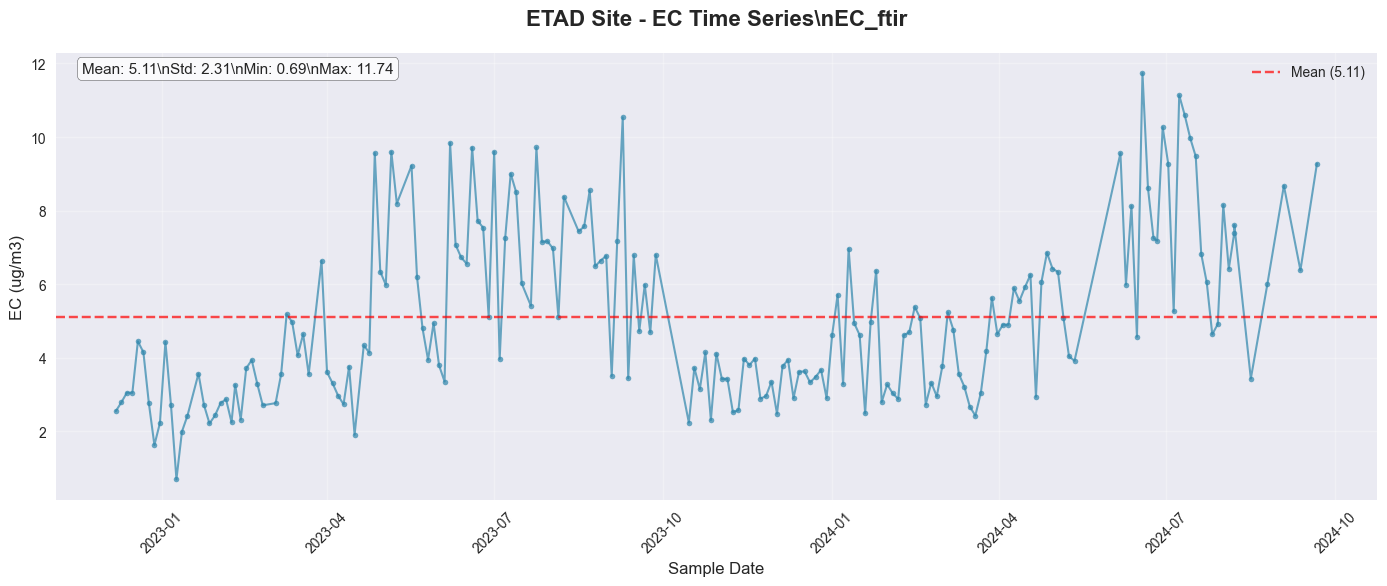

📈 EC Time Series Plot Created
   Mean: 5.107 ± 2.310 ug/m3
   Data points: 190


In [7]:
def plot_parameter_timeseries(param_name, data, color):
    """Generic function to plot any parameter time series"""
    
    if len(data) == 0:
        print(f"❌ No {param_name} data available for plotting")
        return
    
    param_code = PARAMETERS_OF_INTEREST[param_name]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Main time series
    ax.plot(data['SampleDate'], data['Concentration'], 
            'o-', color=color, alpha=0.7, linewidth=1.5, markersize=4)
    
    # Add uncertainty if available
    if 'Uncertainty' in data.columns and not data['Uncertainty'].isna().all():
        uncertainty = data['Uncertainty'].fillna(0)
        ax.fill_between(data['SampleDate'], 
                       data['Concentration'] - uncertainty,
                       data['Concentration'] + uncertainty,
                       alpha=0.2, color=color, label='Uncertainty')
    
    # Formatting
    plot_title = f'{SITE_CODE} Site - {param_name} Time Series\\n{param_code}'
    ax.set_title(plot_title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Sample Date', fontsize=12)
    ax.set_ylabel(f'{param_name} ({data["Concentration_Units"].iloc[0]})', fontsize=12)
    
    # Add statistics box
    mean_val = data['Concentration'].mean()
    std_val = data['Concentration'].std()
    min_val = data['Concentration'].min()
    max_val = data['Concentration'].max()
    
    stats_text = f'Mean: {mean_val:.2f}\\nStd: {std_val:.2f}\\nMin: {min_val:.2f}\\nMax: {max_val:.2f}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Grid and formatting
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Add horizontal line for mean
    ax.axhline(y=mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean ({mean_val:.2f})')
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.savefig(f'{SITE_CODE}_{param_name}_timeseries.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📈 {param_name} Time Series Plot Created")
    print(f"   Mean: {mean_val:.3f} ± {std_val:.3f} {data['Concentration_Units'].iloc[0]}")
    print(f"   Data points: {len(data)}")

# Plot EC time series
if 'EC' in timeseries_data and len(timeseries_data['EC']) > 0:
    plot_parameter_timeseries('EC', timeseries_data['EC'], PLOT_COLORS['EC'])


## 6. Time Series Plot 2: HIPS Fabs (Light Absorption)

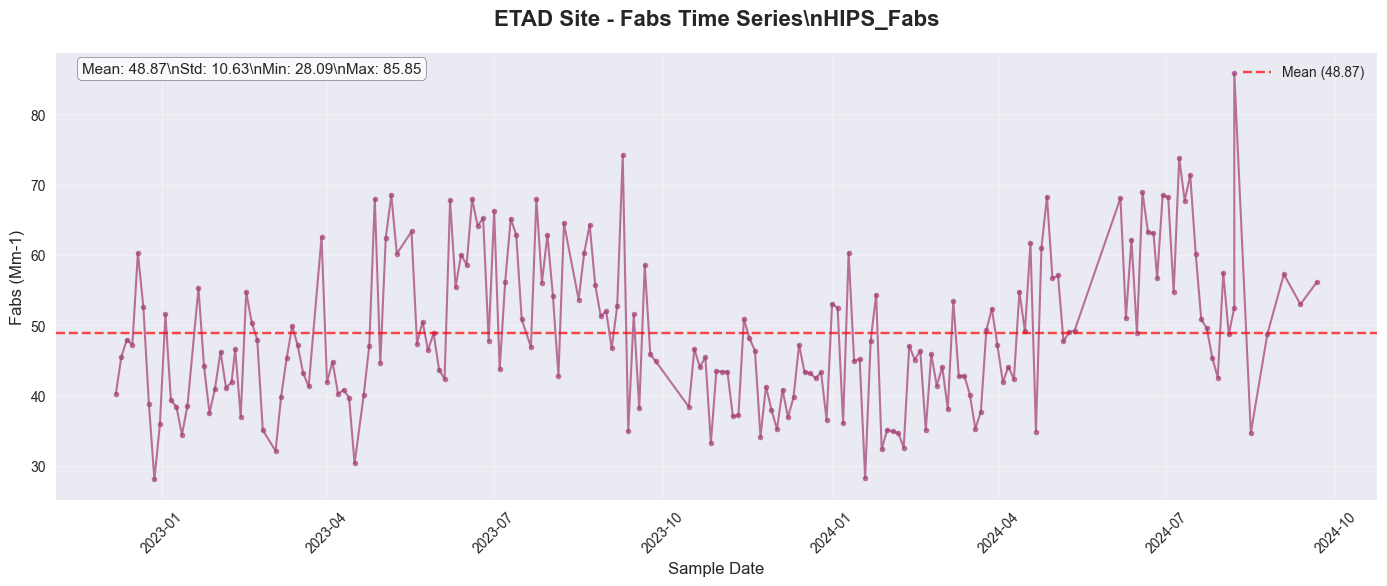

📈 Fabs Time Series Plot Created
   Mean: 48.870 ± 10.634 Mm-1
   Data points: 190


In [8]:
# Plot Fabs time series
if 'Fabs' in timeseries_data and len(timeseries_data['Fabs']) > 0:
    plot_parameter_timeseries('Fabs', timeseries_data['Fabs'], PLOT_COLORS['Fabs'])

## 7. Time Series Plot 3: Iron Concentration

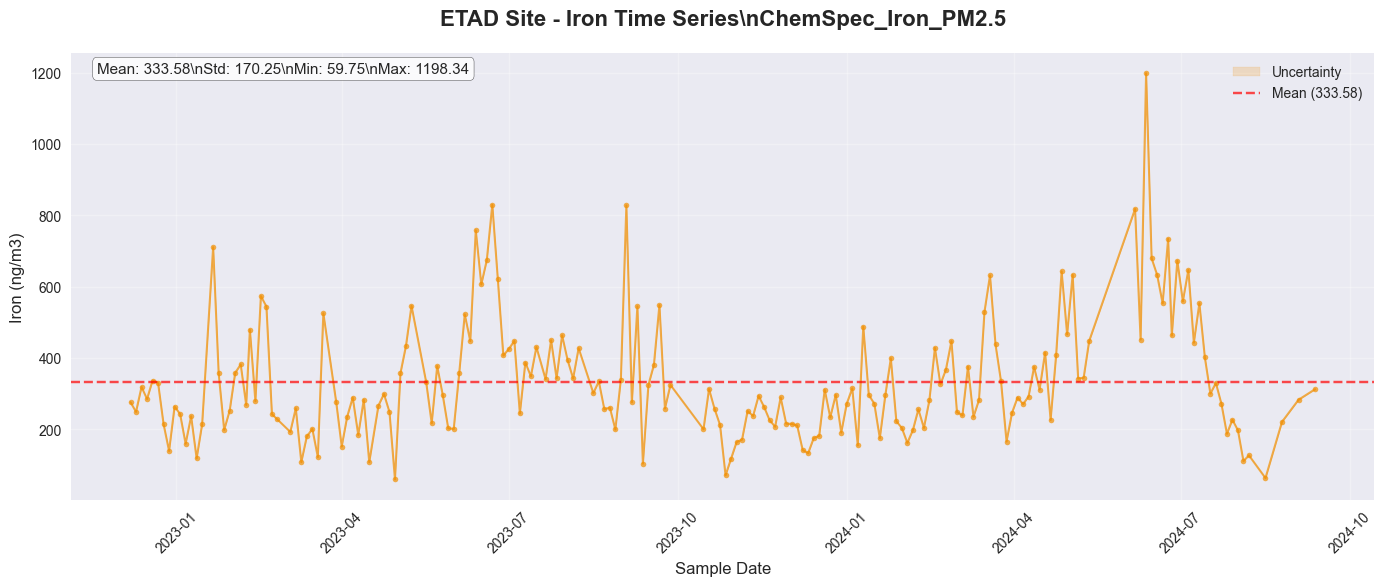

📈 Iron Time Series Plot Created
   Mean: 333.582 ± 170.246 ng/m3
   Data points: 188


In [9]:
# Plot Iron time series
if 'Iron' in timeseries_data and len(timeseries_data['Iron']) > 0:
    plot_parameter_timeseries('Iron', timeseries_data['Iron'], PLOT_COLORS['Iron'])

## 8. Combined Overview Plot

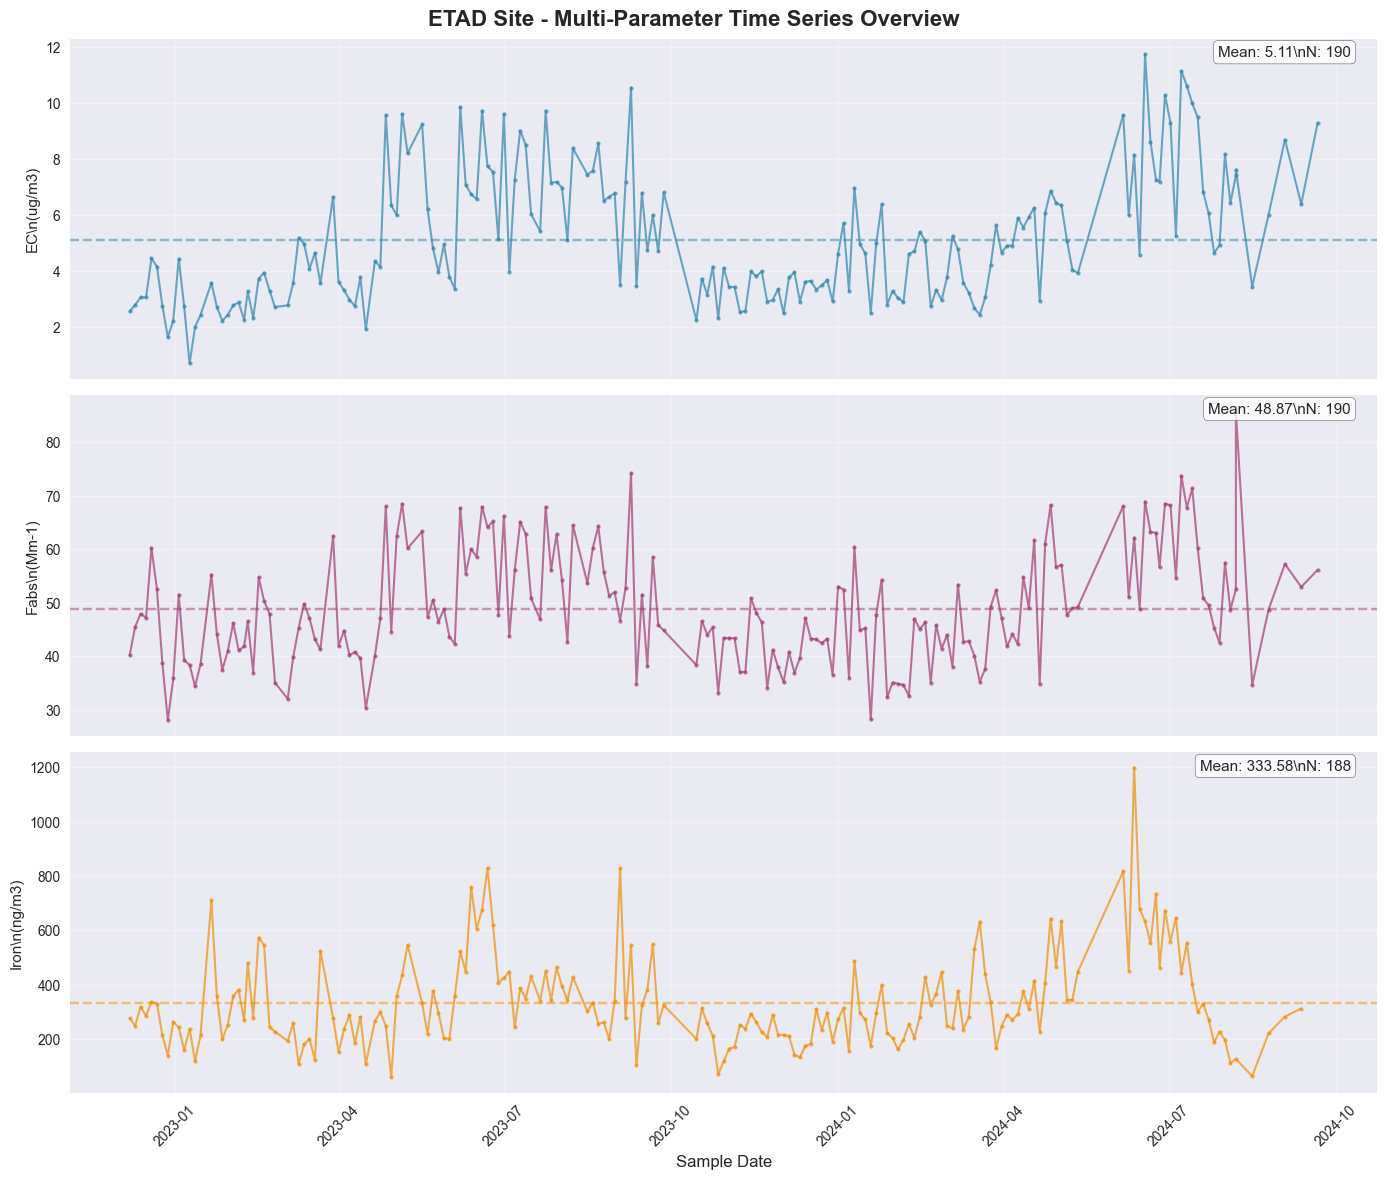

📈 Combined Overview Plot Created


In [10]:
def create_combined_overview():
    """Create a combined overview plot with all available parameters"""
    
    # Filter available data
    available_data = []
    for param_name, data in timeseries_data.items():
        if len(data) > 0:
            available_data.append((data, param_name, PLOT_COLORS.get(param_name, '#333333')))
    
    if len(available_data) < 1:
        print("⚠️  No data available for combined plot")
        return
    
    fig, axes = plt.subplots(len(available_data), 1, figsize=(14, 4*len(available_data)), sharex=True)
    
    if len(available_data) == 1:
        axes = [axes]
    
    for i, (data, param_name, color) in enumerate(available_data):
        ax = axes[i]
        
        # Plot data
        ax.plot(data['SampleDate'], data['Concentration'], 
               'o-', color=color, alpha=0.7, linewidth=1.5, markersize=3)
        
        # Formatting
        ax.set_ylabel(f'{param_name}\\n({data["Concentration_Units"].iloc[0]})', fontsize=11)
        ax.grid(True, alpha=0.3)
        
        # Add mean line
        mean_val = data['Concentration'].mean()
        ax.axhline(y=mean_val, color=color, linestyle='--', alpha=0.5)
        
        # Statistics in corner
        stats = f'Mean: {mean_val:.2f}\\nN: {len(data)}'
        ax.text(0.98, 0.98, stats, transform=ax.transAxes, 
               verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Overall title and formatting
    fig.suptitle(f'{SITE_CODE} Site - Multi-Parameter Time Series Overview', 
                fontsize=16, fontweight='bold', y=0.98)
    axes[-1].set_xlabel('Sample Date', fontsize=12)
    axes[-1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'{SITE_CODE}_combined_timeseries.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📈 Combined Overview Plot Created")

# Create combined plot
create_combined_overview()

## 9. Summary Statistics

In [11]:
print(f"\\n📊 {SITE_CODE} Time Series Analysis Summary")
print("="*60)

for param_name, data in timeseries_data.items():
    if len(data) > 0:
        param_code = PARAMETERS_OF_INTEREST[param_name]
        mean_val = data['Concentration'].mean()
        std_val = data['Concentration'].std()
        min_val = data['Concentration'].min()
        max_val = data['Concentration'].max()
        units = data['Concentration_Units'].iloc[0]
        
        print(f"🔬 {param_name} ({param_code}):")
        print(f"   • {len(data)} measurements from {data['SampleDate'].min().date()} to {data['SampleDate'].max().date()}")
        print(f"   • Mean: {mean_val:.3f} ± {std_val:.3f} {units}")
        print(f"   • Range: {min_val:.3f} - {max_val:.3f} {units}")
        print()

print(f"✅ Analysis complete! Generated plots saved as PNG files.")

\n📊 ETAD Time Series Analysis Summary
🔬 EC (EC_ftir):
   • 190 measurements from 2022-12-07 to 2024-09-21
   • Mean: 5.107 ± 2.310 ug/m3
   • Range: 0.693 - 11.735 ug/m3

🔬 Fabs (HIPS_Fabs):
   • 190 measurements from 2022-12-07 to 2024-09-21
   • Mean: 48.870 ± 10.634 Mm-1
   • Range: 28.086 - 85.853 Mm-1

🔬 Iron (ChemSpec_Iron_PM2.5):
   • 188 measurements from 2022-12-07 to 2024-09-12
   • Mean: 333.582 ± 170.246 ng/m3
   • Range: 59.750 - 1198.340 ng/m3

✅ Analysis complete! Generated plots saved as PNG files.
